In [1]:
!pip install pandas tqdm requests librosa soundfile

In [ ]:
import os, io, random, warnings, subprocess
import numpy as np
import pandas as pd
import pandas as pd
import requests
from tqdm import tqdm

import librosa
import soundfile as sf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)

from tqdm.auto import tqdm
import timm

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


In [30]:
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SR = 32000
N_MELS = 128
N_FFT = 2048
HOP = 512
FMIN = 800
FMAX = 12000

SLICE_SECONDS = 5.0
SLICE_FRAMES = int(SLICE_SECONDS * SR / HOP)
HOP_FRAMES = SLICE_FRAMES // 2

BATCH_SIZE = 32
EPOCHS = 15
LR = 3e-4

CAP_PER_CLASS = 175

MEL_ROOT = "/kaggle/working/mel_cache"
os.makedirs(MEL_ROOT, exist_ok=True)

MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()


In [3]:
data_1 = "/kaggle/input/fffffffff/train_combined.csv"
data_2 = "/kaggle/input/fffffffff/train_ext.csv"
TRAIN_AUDIO = "/kaggle/input/birdsong-recognition/train_audio"

In [4]:
df_1 = pd.read_csv(data_1, low_memory=False)
df_2 = pd.read_csv(data_2, low_memory=False)

In [5]:
df_m = pd.merge(
    df_1,
    df_2,
    on="filename",
    how="outer",
)

In [6]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43934 entries, 0 to 43933
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating_x            43934 non-null  float64
 1   playback_used_x     40333 non-null  object 
 2   ebird_code_x        43934 non-null  object 
 3   channels_x          43934 non-null  object 
 4   date_x              43934 non-null  object 
 5   duration_x          43934 non-null  int64  
 6   filename            43934 non-null  object 
 7   species_x           43934 non-null  object 
 8   title_x             43934 non-null  object 
 9   secondary_labels_x  43934 non-null  object 
 10  bird_seen_x         40220 non-null  object 
 11  sci_name_x          43934 non-null  object 
 12  location_x          43934 non-null  object 
 13  latitude_x          43512 non-null  object 
 14  sampling_rate_x     43934 non-null  object 
 15  type_x              43905 non-null  object 
 16  elev

In [7]:
df = df_m.copy()

cols_x = [c for c in df.columns if c.endswith("_x")]

for col_x in cols_x:
    base = col_x[:-2]
    col_y = base + "_y"

    if col_y in df.columns:
        df[base] = df[col_x].combine_first(df[col_y])
    else:
        df[base] = df[col_x]

/tmp/ipykernel_47/599755247.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[col_x].combine_first(df[col_y])
/tmp/ipykernel_47/599755247.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df[base] = df[col_x].combine_first(df[col_y])


In [8]:
df = df.drop(columns=[c for c in df.columns if c.endswith("_x") or c.endswith("_y")])


In [9]:
import numpy as np

numeric_cols = [
    "latitude", "longitude", "duration", "rating", "xc_id"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [10]:
print("Columns:", len(df.columns))
print("Rows:", len(df))
print("Unique files:", df["filename"].nunique())
df.info()

Columns: 29
Rows: 43934
Unique files: 43934
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43934 entries, 0 to 43933
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          43934 non-null  object 
 1   rating            43934 non-null  float64
 2   playback_used     40333 non-null  object 
 3   ebird_code        43934 non-null  object 
 4   channels          43934 non-null  object 
 5   date              43934 non-null  object 
 6   duration          43934 non-null  int64  
 7   species           43934 non-null  object 
 8   title             43934 non-null  object 
 9   secondary_labels  43934 non-null  object 
 10  bird_seen         40220 non-null  object 
 11  sci_name          43934 non-null  object 
 12  location          43934 non-null  object 
 13  latitude          43286 non-null  float64
 14  sampling_rate     43934 non-null  object 
 15  type              43905 non-null  object 
 

In [11]:
df = df[df["rating"]>4]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13938 entries, 5 to 43930
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          13938 non-null  object 
 1   rating            13938 non-null  float64
 2   playback_used     13065 non-null  object 
 3   ebird_code        13938 non-null  object 
 4   channels          13938 non-null  object 
 5   date              13938 non-null  object 
 6   duration          13938 non-null  int64  
 7   species           13938 non-null  object 
 8   title             13938 non-null  object 
 9   secondary_labels  13938 non-null  object 
 10  bird_seen         13114 non-null  object 
 11  sci_name          13938 non-null  object 
 12  location          13938 non-null  object 
 13  latitude          13877 non-null  float64
 14  sampling_rate     13938 non-null  object 
 15  type              13938 non-null  object 
 16  elevation         13938 non-null  object 
 17

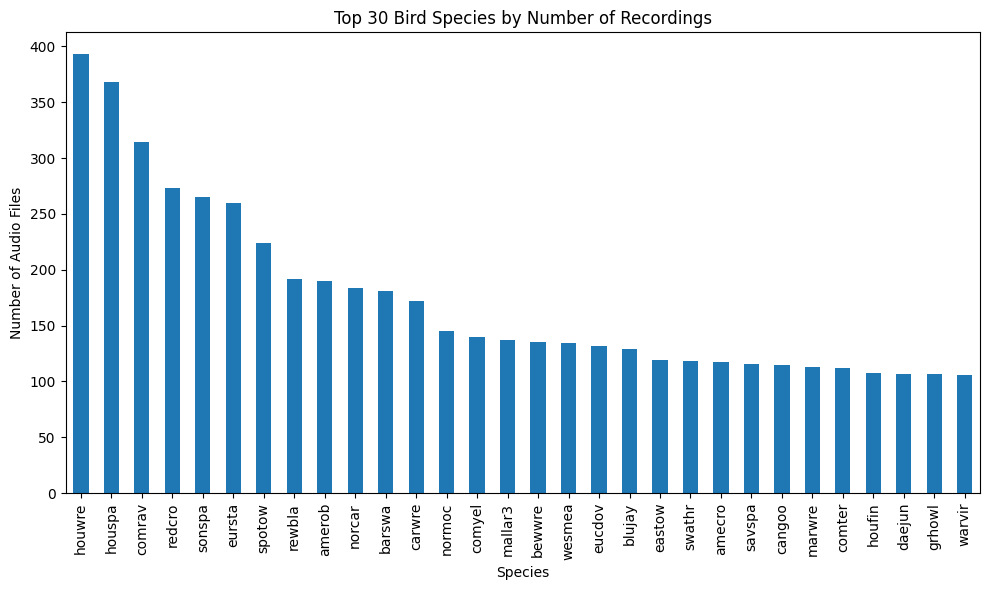

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df["ebird_code"].value_counts().head(30).plot(kind="bar")
plt.title("Top 30 Bird Species by Number of Recordings")
plt.xlabel("Species")
plt.ylabel("Number of Audio Files")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

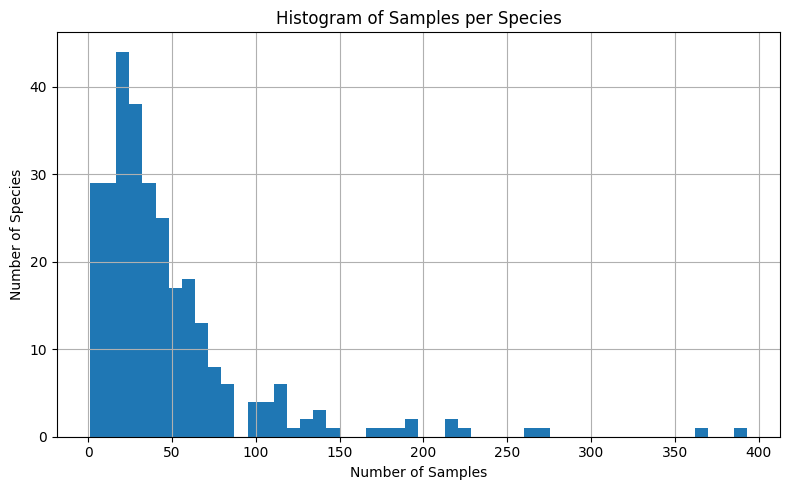

In [14]:
plt.figure(figsize=(8, 5))
df["primary_label"].value_counts().hist(bins=50)
plt.title("Histogram of Samples per Species")
plt.xlabel("Number of Samples")
plt.ylabel("Number of Species")
plt.tight_layout()
plt.show()

In [15]:
species_counts = df["primary_label"].value_counts()

In [16]:
df_100 = df[df["primary_label"].isin(species_counts[species_counts > 100].index)].reset_index(drop=True)

print("Species (>100):", df_100["primary_label"].nunique())
print("Samples:", len(df_100))

Species (>100): 29
Samples: 4934


In [17]:
df_50 = df[df["primary_label"].isin(species_counts[species_counts > 50].index)].reset_index(drop=True)

print("Species (>50):", df_50["primary_label"].nunique())
print("Samples:", len(df_50))

Species (>50): 89
Samples: 8997


In [18]:
CSV_PATHS = "/kaggle/input/birdcall/ebird_audio_paths.csv"
df_paths = pd.read_csv(CSV_PATHS, low_memory=False)

In [19]:
def prepare_df_paths(df_paths):
    dfp = df_paths.copy()
    dfp["filename"] = (
        dfp["audio_path"]
        .astype(str)
        .str.replace("\\", "/", regex=False)
        .apply(lambda x: x.split("/")[-1])
    )

    return dfp


def create_df(df_100, df_paths):
    dfp = prepare_df_paths(df_paths)
    print("df_100 filenames:", df_100["filename"].nunique())
    print("df_paths filenames:", dfp["filename"].nunique())
    print(
        "Intersection:",
        len(set(df_100["filename"]) & set(dfp["filename"]))
    )

    df = pd.merge(
        df_100,
        dfp[["filename", "audio_path"]],
        on="filename",
        how="inner"
    )

    return df


In [20]:
df = create_df(df_100, df_paths)

df_100 filenames: 4934
df_paths filenames: 4934
Intersection: 4934


In [21]:
df.head()

,filename,rating,playback_used,ebird_code,channels,date,duration,species,title,secondary_labels,...,xc_id,url,country,author,primary_label,longitude,time,recordist,license,audio_path
0,XC102969.mp3,5.0,no,warvir,1 (mono),2012-06-01,73,Warbling Vireo,XC102969 Warbling Vireo (Vireo gilvus),[],...,102969,https://www.xeno-canto.org/102969,United States,Jonathon Jongsma,Vireo gilvus_Warbling Vireo,-92.9620,07:30,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,./train_audio_xc\warvir\XC102969.mp3
1,XC104512.mp3,5.0,NaN,daejun,1 (mono),2012-06-19,4,Dark-eyed Junco,XC104512 Dark-eyed Junco (Junco hyemalis),[],...,104512,https://www.xeno-canto.org/104512,United States,Jonathon Jongsma,Junco hyemalis_Dark-eyed Junco,-103.4808,06:56,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,./train_audio_xc\daejun\XC104512.mp3
2,XC104514.mp3,4.5,no,daejun,1 (mono),2012-06-22,35,Dark-eyed Junco,XC104514 Dark-eyed Junco (Junco hyemalis),"['Colaptes auratus_Northern Flicker', 'Melospi...",...,104514,https://www.xeno-canto.org/104514,United States,Jonathon Jongsma,Junco hyemalis_Dark-eyed Junco,-103.4808,06:41,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,./train_audio_xc\daejun\XC104514.mp3
3,XC104527.mp3,4.5,NaN,spotow,1 (mono),2012-06-21,44,Spotted Towhee,XC104527 Spotted Towhee (Pipilo maculatus),['Sturnella neglecta_Western Meadowlark'],...,104527,https://www.xeno-canto.org/104527,United States,Jonathon Jongsma,Pipilo maculatus_Spotted Towhee,-103.3862,11:26,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,./train_audio_xc\spotow\XC104527.mp3
4,XC104528.mp3,4.5,NaN,spotow,1 (mono),2012-06-21,81,Spotted Towhee,XC104528 Spotted Towhee (Pipilo maculatus),['Sturnella neglecta_Western Meadowlark'],...,104528,https://www.xeno-canto.org/104528,United States,Jonathon Jongsma,Pipilo maculatus_Spotted Towhee,-103.3862,11:35,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0,./train_audio_xc\spotow\XC104528.mp3


In [22]:
AUDIO_ROOT = "/kaggle/input/baudio/train_audio"

def validate_df(df):
    """
    Builds full audio paths and removes rows with missing files.
    """
    df = df.copy()

    filepaths = []
    exists = []

    print("Checking audio file existence...")

    for _, r in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(
            AUDIO_ROOT,
            str(r["ebird_code"]),
            str(r["filename"])
        )
        filepaths.append(path)
        exists.append(os.path.exists(path))

    df["filepath"] = filepaths
    df["file_exists"] = exists

    print(f"Found {sum(exists)} / {len(df)} files")
    print(f"Removed {len(df) - sum(exists)} missing files")

    # Drop missing
    df = df[df["file_exists"]].drop(columns=["file_exists"]).reset_index(drop=True)

    return df

In [23]:
df_train = validate_df(df_100)
df_train.info()

Checking audio file existence...


100%|██████████| 4934/4934 [00:07<00:00, 662.63it/s]


Found 4910 / 4934 files
Removed 24 missing files
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4910 entries, 0 to 4909
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          4910 non-null   object 
 1   rating            4910 non-null   float64
 2   playback_used     4569 non-null   object 
 3   ebird_code        4910 non-null   object 
 4   channels          4910 non-null   object 
 5   date              4910 non-null   object 
 6   duration          4910 non-null   int64  
 7   species           4910 non-null   object 
 8   title             4910 non-null   object 
 9   secondary_labels  4910 non-null   object 
 10  bird_seen         4601 non-null   object 
 11  sci_name          4910 non-null   object 
 12  location          4910 non-null   object 
 13  latitude          4891 non-null   float64
 14  sampling_rate     4910 non-null   object 
 15  type              4910 non-null   object

In [24]:
cols = ["ebird_code", "filepath", "species"]
dataset = df_train[cols]

In [25]:
dataset = dataset.rename(columns={"species": "label", "filepath":"filename"})

In [26]:
dataset = dataset.rename(columns={"species": "label", "audio_path":"filename"})

In [27]:
dataset.head()

,ebird_code,filename,label
0,warvir,/kaggle/input/baudio/train_audio/warvir/XC1029...,Warbling Vireo
1,daejun,/kaggle/input/baudio/train_audio/daejun/XC1045...,Dark-eyed Junco
2,daejun,/kaggle/input/baudio/train_audio/daejun/XC1045...,Dark-eyed Junco
3,spotow,/kaggle/input/baudio/train_audio/spotow/XC1045...,Spotted Towhee
4,spotow,/kaggle/input/baudio/train_audio/spotow/XC1045...,Spotted Towhee


In [28]:
!pip install timm librosa soundfile tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [31]:
dataset = dataset.dropna(subset=["filename", "label"]).reset_index(drop=True)

if CAP_PER_CLASS:
    dataset = (
        dataset.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(n=min(len(x), CAP_PER_CLASS), random_state=SEED))
        .reset_index(drop=True)
    )

dataset["mel_id"] = dataset.index.astype(str)


In [32]:
dataset.head()

,ebird_code,filename,label,mel_id
0,amecro,/kaggle/input/baudio/train_audio/amecro/XC1972...,American Crow,0
1,amecro,/kaggle/input/baudio/train_audio/amecro/XC1145...,American Crow,1
2,amecro,/kaggle/input/baudio/train_audio/amecro/XC2938...,American Crow,2
3,amecro,/kaggle/input/baudio/train_audio/amecro/XC1972...,American Crow,3
4,amecro,/kaggle/input/baudio/train_audio/amecro/XC1145...,American Crow,4


In [33]:
labels = sorted(dataset["label"].unique())
label2idx = {l: i for i, l in enumerate(labels)}
idx2label = {i: l for l, i in label2idx.items()}
NUM_CLASSES = len(labels)

train_df, temp_df = train_test_split(
    dataset,
    test_size=0.30,
    stratify=dataset["label"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=SEED
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)


In [34]:
def safe_load_audio(path, sr=SR):
    try:
        y, sr = librosa.load(path, sr=sr, mono=True)
        return y, sr
    except Exception:
        try:
            cmd = [
                "ffmpeg", "-loglevel", "quiet",
                "-i", path, "-ar", str(sr),
                "-ac", "1", "-f", "wav", "pipe:1"
            ]
            wav = subprocess.check_output(cmd)
            with io.BytesIO(wav) as f:
                y, sr = sf.read(f, dtype="float32")
            if y.ndim > 1:
                y = y.mean(axis=1)
            return y, sr
        except Exception:
            return np.zeros(sr), sr


In [35]:
def compute_mel(path):
    y, sr = safe_load_audio(path)
    y = y / (np.max(np.abs(y)) + 1e-6)

    mel = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP,
        fmin=FMIN, fmax=FMAX
    )

    mel = librosa.power_to_db(mel, ref=np.max)
    mel = (mel + 80.0) / 80.0
    mel = np.clip(mel, -1.0, 1.0)

    return mel.astype(np.float32)


In [36]:
for _, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Caching mel"):
    path = os.path.join(MEL_ROOT, f"{row.mel_id}.npy")
    if not os.path.exists(path):
        np.save(path, compute_mel(row.filename))


Caching mel:   0%|          | 0/4147 [00:00<?, ?it/s]

Note: Illegal Audio-MPEG-Header 0x72616368 at offset 842105.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x64616517 at offset 2417920.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x64757320 at offset 1315234.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x73746963 at offset 1043561.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x20284869 at offset 1831414.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 320074.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MP

In [37]:
def spec_augment(mel, fmask=16, tmask=32):
    mel = mel.copy()
    f = np.random.randint(0, min(fmask, mel.shape[0]))
    t = np.random.randint(0, min(tmask, mel.shape[1]))
    if f > 0:
        mel[np.random.randint(0, mel.shape[0]-f):][:f] = 0
    if t > 0:
        mel[:, np.random.randint(0, mel.shape[1]-t):][:, :t] = 0
    return mel


In [38]:
class MelTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mel = np.load(f"{MEL_ROOT}/{row.mel_id}.npy")

        if mel.shape[1] > SLICE_FRAMES:
            start = np.random.randint(0, mel.shape[1]-SLICE_FRAMES)
            mel = mel[:, start:start+SLICE_FRAMES]
        else:
            mel = np.pad(mel, ((0,0),(0,SLICE_FRAMES-mel.shape[1])))

        mel = spec_augment(mel)
        return torch.tensor(mel).unsqueeze(0), torch.tensor(label2idx[row.label])


In [39]:
class MelEvalDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mel = np.load(f"{MEL_ROOT}/{row.mel_id}.npy")

        slices = []
        for s in range(0, max(1, mel.shape[1]-SLICE_FRAMES+1), HOP_FRAMES):
            clip = mel[:, s:s+SLICE_FRAMES]
            if clip.shape[1] < SLICE_FRAMES:
                clip = np.pad(clip, ((0,0),(0,SLICE_FRAMES-clip.shape[1])))
            slices.append(clip)

        return torch.tensor(np.stack(slices)).unsqueeze(1), torch.tensor(label2idx[row.label])


In [40]:
def evaluate(model, ds, desc):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in tqdm(ds, desc=desc, leave=False):
            x = x.to(DEVICE)
            logits = model(x)
            pred = logits.mean(dim=0).argmax().item()
            y_true.append(y.item())
            y_pred.append(pred)

    return (
        f1_score(y_true, y_pred, average="macro"),
        y_true, y_pred
    )


In [41]:
def train_model(model, name):
    train_loader = DataLoader(
        MelTrainDataset(train_df),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )
    val_ds = MelEvalDataset(val_df)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {"loss": [], "val_f1": []}
    best_f1, best_state = -1, None

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for x, y in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}/{EPOCHS}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_f1, _, _ = evaluate(model, val_ds, f"{name} Val")
        history["loss"].append(total_loss/len(train_loader))
        history["val_f1"].append(val_f1)

        print(f"{name} | Epoch {epoch+1} | Val Macro F1 = {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict()

    torch.save(best_state, f"{MODEL_DIR}/{name}_best.pt")
    model.load_state_dict(best_state)
    return model, history


In [43]:
effnet = timm.create_model(
    "efficientnet_b3", pretrained=True,
    in_chans=1, num_classes=NUM_CLASSES
).to(DEVICE)

resnet = timm.create_model(
    "resnet34", pretrained=True,
    in_chans=1, num_classes=NUM_CLASSES
).to(DEVICE)

effnet, eff_hist = train_model(effnet, "efficientnet_b3")
resnet, res_hist = train_model(resnet, "resnet34")


efficientnet_b3 Epoch 1/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 1 | Val Macro F1 = 0.5280


efficientnet_b3 Epoch 2/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 2 | Val Macro F1 = 0.6945


efficientnet_b3 Epoch 3/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 3 | Val Macro F1 = 0.7795


efficientnet_b3 Epoch 4/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 4 | Val Macro F1 = 0.8328


efficientnet_b3 Epoch 5/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 5 | Val Macro F1 = 0.8263


efficientnet_b3 Epoch 6/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 6 | Val Macro F1 = 0.8407


efficientnet_b3 Epoch 7/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 7 | Val Macro F1 = 0.8366


efficientnet_b3 Epoch 8/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 8 | Val Macro F1 = 0.8353


efficientnet_b3 Epoch 9/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 9 | Val Macro F1 = 0.8350


efficientnet_b3 Epoch 10/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 10 | Val Macro F1 = 0.8352


efficientnet_b3 Epoch 11/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 11 | Val Macro F1 = 0.8453


efficientnet_b3 Epoch 12/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 12 | Val Macro F1 = 0.8555


efficientnet_b3 Epoch 13/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 13 | Val Macro F1 = 0.8497


efficientnet_b3 Epoch 14/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 14 | Val Macro F1 = 0.8553


efficientnet_b3 Epoch 15/15:   0%|          | 0/91 [00:00<?, ?it/s]

efficientnet_b3 Val:   0%|          | 0/622 [00:00<?, ?it/s]

efficientnet_b3 | Epoch 15 | Val Macro F1 = 0.8638


resnet34 Epoch 1/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 1 | Val Macro F1 = 0.0617


resnet34 Epoch 2/15:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()Exception ignored in: self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
          File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():if w.is_

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 2 | Val Macro F1 = 0.2902


resnet34 Epoch 3/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 3 | Val Macro F1 = 0.5153


resnet34 Epoch 4/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 4 | Val Macro F1 = 0.6314


resnet34 Epoch 5/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 5 | Val Macro F1 = 0.6888


resnet34 Epoch 6/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 6 | Val Macro F1 = 0.7347


resnet34 Epoch 7/15:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive():     
  ^  ^ ^  ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 7 | Val Macro F1 = 0.7743


resnet34 Epoch 8/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 8 | Val Macro F1 = 0.8120


resnet34 Epoch 9/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 9 | Val Macro F1 = 0.8104


resnet34 Epoch 10/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 10 | Val Macro F1 = 0.8086


resnet34 Epoch 11/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 11 | Val Macro F1 = 0.8225


resnet34 Epoch 12/15:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a69dd99c7c0>    if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers() 
 ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
^ ^  ^ ^  ^ ^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^  ^ ^^ 
    File "/usr/lib/

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 12 | Val Macro F1 = 0.8174


resnet34 Epoch 13/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 13 | Val Macro F1 = 0.8451


resnet34 Epoch 14/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 14 | Val Macro F1 = 0.8470


resnet34 Epoch 15/15:   0%|          | 0/91 [00:00<?, ?it/s]

resnet34 Val:   0%|          | 0/622 [00:00<?, ?it/s]

resnet34 | Epoch 15 | Val Macro F1 = 0.8493


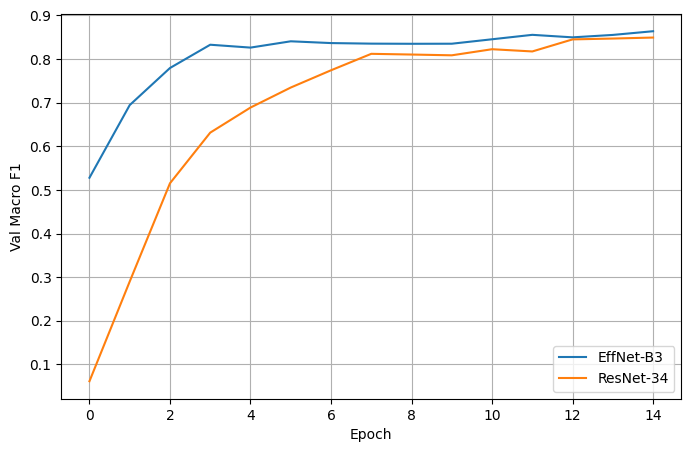

In [45]:
plt.figure(figsize=(8,5))
plt.plot(eff_hist["val_f1"], label="EffNet-B3")
plt.plot(res_hist["val_f1"], label="ResNet-34")
plt.xlabel("Epoch")
plt.ylabel("Val Macro F1")
plt.legend()
plt.grid()
plt.show()


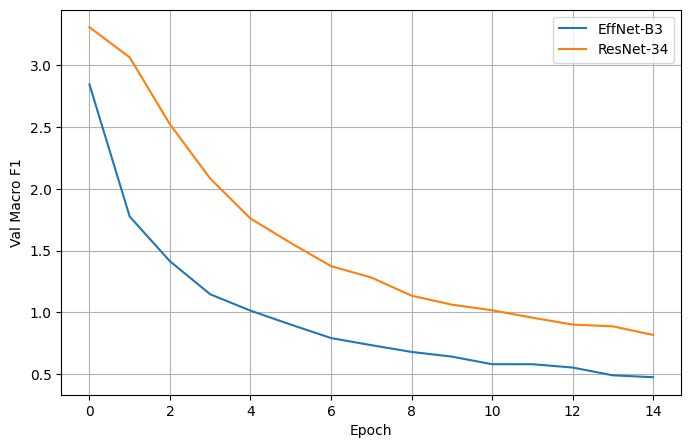

In [46]:
plt.figure(figsize=(8,5))
plt.plot(eff_hist["loss"], label="EffNet-B3")
plt.plot(res_hist["loss"], label="ResNet-34")
plt.xlabel("Epoch")
plt.ylabel("Val Macro F1")
plt.legend()
plt.grid()
plt.show()

In [48]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [52]:
test_ds = MelEvalDataset(test_df)

eff_f1, eff_y_true, eff_y_pred = evaluate(effnet, test_ds, "EffNet Test")
res_f1, res_y_true, res_y_pred = evaluate(resnet, test_ds, "ResNet Test")

plot_cm(eff_y_true, eff_y_pred, "EfficientNet-B3 Confusion Matrix")
plot_cm(res_y_true, res_y_pred, "ResNet-34 Confusion Matrix")

print("EffNet Test F1:", eff_f1)
print("ResNet Test F1:", res_f1)


EffNet Test:   0%|          | 0/623 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 588.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 60.19 MiB is free. Process 3433 has 14.68 GiB memory in use. Of the allocated memory 11.66 GiB is allocated by PyTorch, and 2.88 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [57]:
import json
import os

LABELS_PATH = "/kaggle/working/labels.json"

with open(LABELS_PATH, "w") as f:
    json.dump(idx2label, f, indent=2)

print("Saved to:", LABELS_PATH)

Saved to: /kaggle/working/labels.json
